# Autoencoder


In [2]:
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

### Data Normalization

In [5]:
folder_ccf = "SS_CCF"
folder_model = "SS_models"

txt_files = sorted(glob.glob(os.path.join(folder_ccf, "*.txt")))

selected_columns = []
selected_model = []

for file in txt_files:
    ccfs = np.loadtxt(file)  # (145, 400)

    # Escollim una columna aleatòria
    random_col = np.random.randint(ccfs.shape[1])
    col_data = ccfs[:, random_col]  # (145,)
    selected_columns.append(col_data)

    # Obtenim el nom base del fitxer per buscar el corresponent a SS_models
    basename = os.path.basename(file)  # "sim_34.txt"
    model_file = os.path.join(folder_model, basename)

    # Carreguem el fitxer corresponent de models
    model_data = np.loadtxt(model_file)  # ex. (400, 7)

    # Agafem la fila corresponent a la columna aleatòria
    row = model_data[random_col]  # (7,)
    selected_model.append(row)

# Finalment:
ccf_data = np.stack(selected_columns)           # shape: (n_files, 145)
model_data = np.stack(selected_model) # shape: (n_files, 7)

print(f"CCF shape: {ccf_data.shape}")
print(f"Model shape: {model_data.shape}")

CCF shape: (4000, 145)
Model shape: (4000, 7)


Shape of data: (4000, 145)


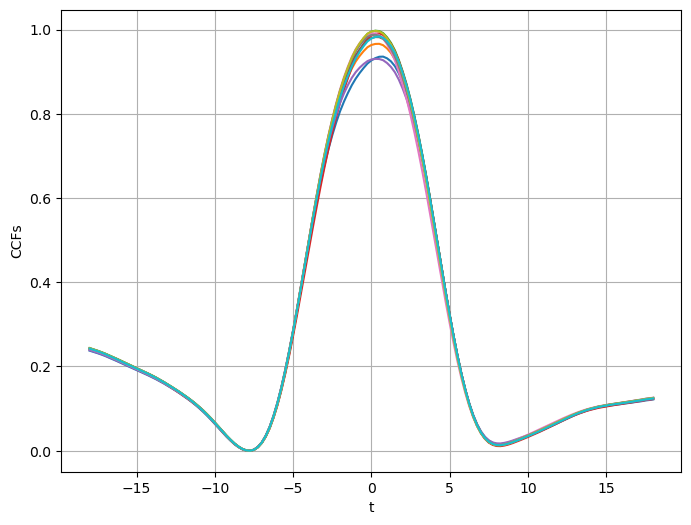

Shape of data: torch.Size([3400, 1, 145])


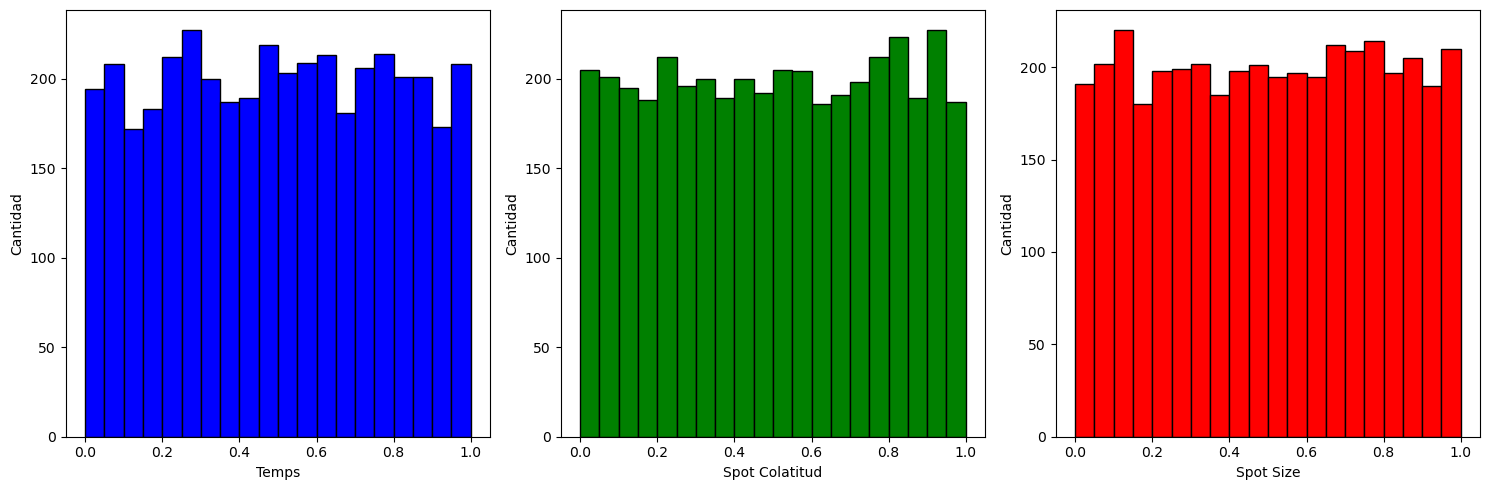

In [46]:
time = model_data[:,0]
spot_lat = model_data[:,1]
spot_size = model_data[:,2]

t_norm = (time - time.min()) / (time.max() - time.min())
lat_norm = (spot_lat - spot_lat .min()) / (spot_lat .max() - spot_lat .min())
size_norm = (spot_size - spot_size.min()) / (spot_size.max() - spot_size.min())

params = np.vstack([t_norm, lat_norm, size_norm]).T

steps_sampling = np.arange(-18.0, 18.0 + 0.25, 0.25)
ccf_data = (ccf_data - ccf_data.min()) / (ccf_data.max() - ccf_data.min())
print(f"Shape of data: {ccf_data.shape}")  # → (n_files, 145)

plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(steps_sampling, ccf_data[i], label=f'CCF {i+1}')

plt.xlabel("t")
plt.ylabel("CCFs")
plt.grid()
plt.show()

# 85% train, 15% test
ccf_train, ccf_test, params_train, params_test = train_test_split(ccf_data, params, test_size=0.15, random_state=26)
#ccf_train, ccf_test = train_test_split(data, test_size=0.15, random_state=26)

ccf_train = torch.tensor(ccf_train, dtype=torch.float32).reshape(-1, 1, 145)
ccf_test = torch.tensor(ccf_test, dtype=torch.float32).reshape(-1, 1, 145)
params_train = torch.tensor(params_train, dtype=torch.float32)
params_test = torch.tensor(params_test, dtype=torch.float32)

print(f"Shape of data: {ccf_train.shape}")  # → (n_files, 145)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(t_norm, bins=20, color='b', edgecolor='black')
plt.xlabel('Temps')
plt.ylabel('Cantidad')

plt.subplot(1, 3, 2)
plt.hist(lat_norm, bins=20, color='g', edgecolor='black')
plt.xlabel('Spot Colatitud')
plt.ylabel('Cantidad')

plt.subplot(1, 3, 3)
plt.hist(size_norm, bins=20, color='r', edgecolor='black')
plt.xlabel('Spot Size')
plt.ylabel('Cantidad')


plt.tight_layout()
plt.show()

In [48]:
print(type(ccf_train), type(params_train))
print(ccf_train.shape)
print(params_train.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([3400, 1, 145])
torch.Size([3400, 3])


### Testing the AE model

#### Training and Validation set

Epoch [0/3000], Train Loss: 0.034038
Epoch [10/3000], Train Loss: 0.000046
Epoch [20/3000], Train Loss: 0.000043
Epoch [30/3000], Train Loss: 0.000043
Epoch [40/3000], Train Loss: 0.000042
Epoch [50/3000], Train Loss: 0.000042
Epoch [60/3000], Train Loss: 0.000042
Epoch [70/3000], Train Loss: 0.000042
Epoch [80/3000], Train Loss: 0.000042
Epoch [90/3000], Train Loss: 0.000042
Epoch [100/3000], Train Loss: 0.000042
Epoch [110/3000], Train Loss: 0.000042
Epoch [120/3000], Train Loss: 0.000042
Epoch [130/3000], Train Loss: 0.000042
Epoch [140/3000], Train Loss: 0.000042
Epoch [150/3000], Train Loss: 0.000042
Epoch [160/3000], Train Loss: 0.000041
Epoch [170/3000], Train Loss: 0.000042
Epoch [180/3000], Train Loss: 0.000042
Epoch [190/3000], Train Loss: 0.000042
Epoch [200/3000], Train Loss: 0.000041
Epoch [210/3000], Train Loss: 0.000042
Epoch [220/3000], Train Loss: 0.000042
Epoch [230/3000], Train Loss: 0.000042
Epoch [240/3000], Train Loss: 0.000042
Epoch [250/3000], Train Loss: 0.0000

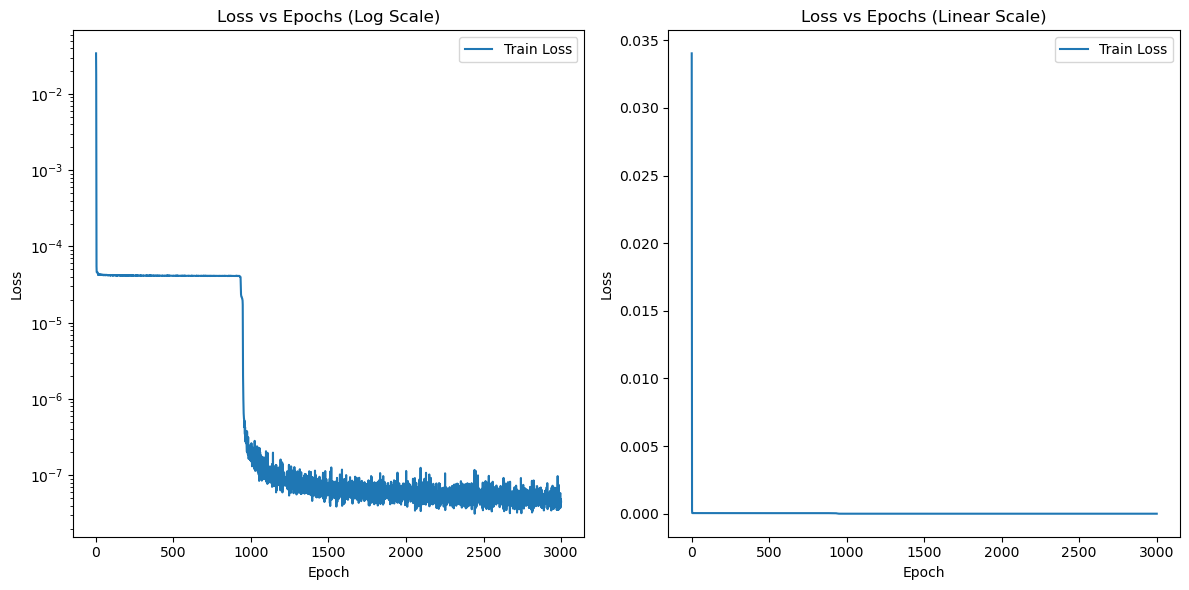

In [57]:
class AEConv(nn.Module):
    def __init__(self):
        super(AEConv, self).__init__()

        self.encoder_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=4, out_channels=12, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.flatten = nn.Flatten()
        
        self.encoder_fc = nn.Sequential(
            nn.Linear(12 * 145, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 3),
            nn.Tanh()
        )
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 12 * 145),
            nn.ReLU()
        )
        self.unflatten = nn.Unflatten(1, (12, 145))
        
        self.decoder_conv = nn.Sequential(
        nn.Conv1d(in_channels=12, out_channels=4, kernel_size=3, padding=1),
                    nn.ReLU(),
                    nn.Conv1d(in_channels=4, out_channels=1, kernel_size=3, padding=1),
                    nn.Sigmoid()
                )
        
    def forward(self, x):
        x = self.encoder_conv(x)
        x = self.flatten(x)
        z = self.encoder_fc(x)

        x = self.decoder_fc(z)
        x = self.unflatten(x)
        x = self.decoder_conv(x)

        return x, z

        
        
# Crear el modelo
model = AEConv()
lr=0.0005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
num_epochs = 3000
batch_size = 8
dataset = torch.utils.data.TensorDataset(ccf_train,params_train)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
train_losses = []


for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        outputs, latent = model(batch_x)
        loss = criterion(outputs, batch_x)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item() * batch_x.size(0)
        
    
    avg_train_loss = running_train_loss / len(dataloader.dataset)
    train_losses.append(avg_train_loss)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Train Loss: {avg_train_loss:.6f}")
        
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))

# Log scale
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Log Scale)")
plt.legend()

# Linear scale
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Linear Scale)")
plt.legend()

plt.tight_layout()
plt.show()

#### Evaluation set

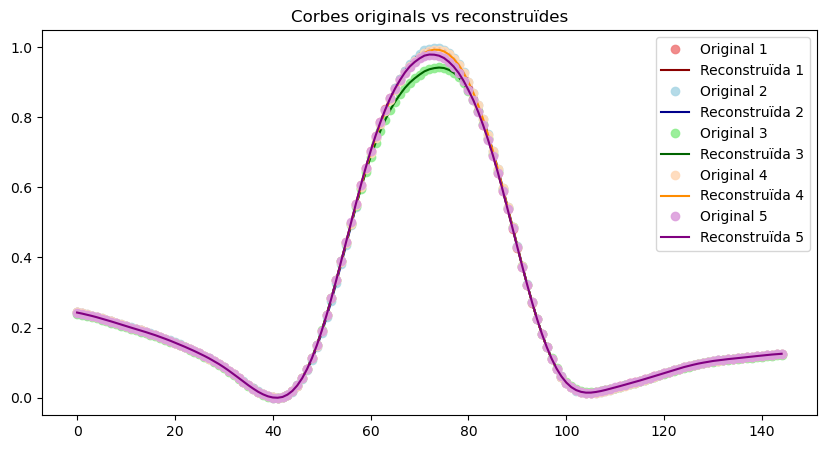

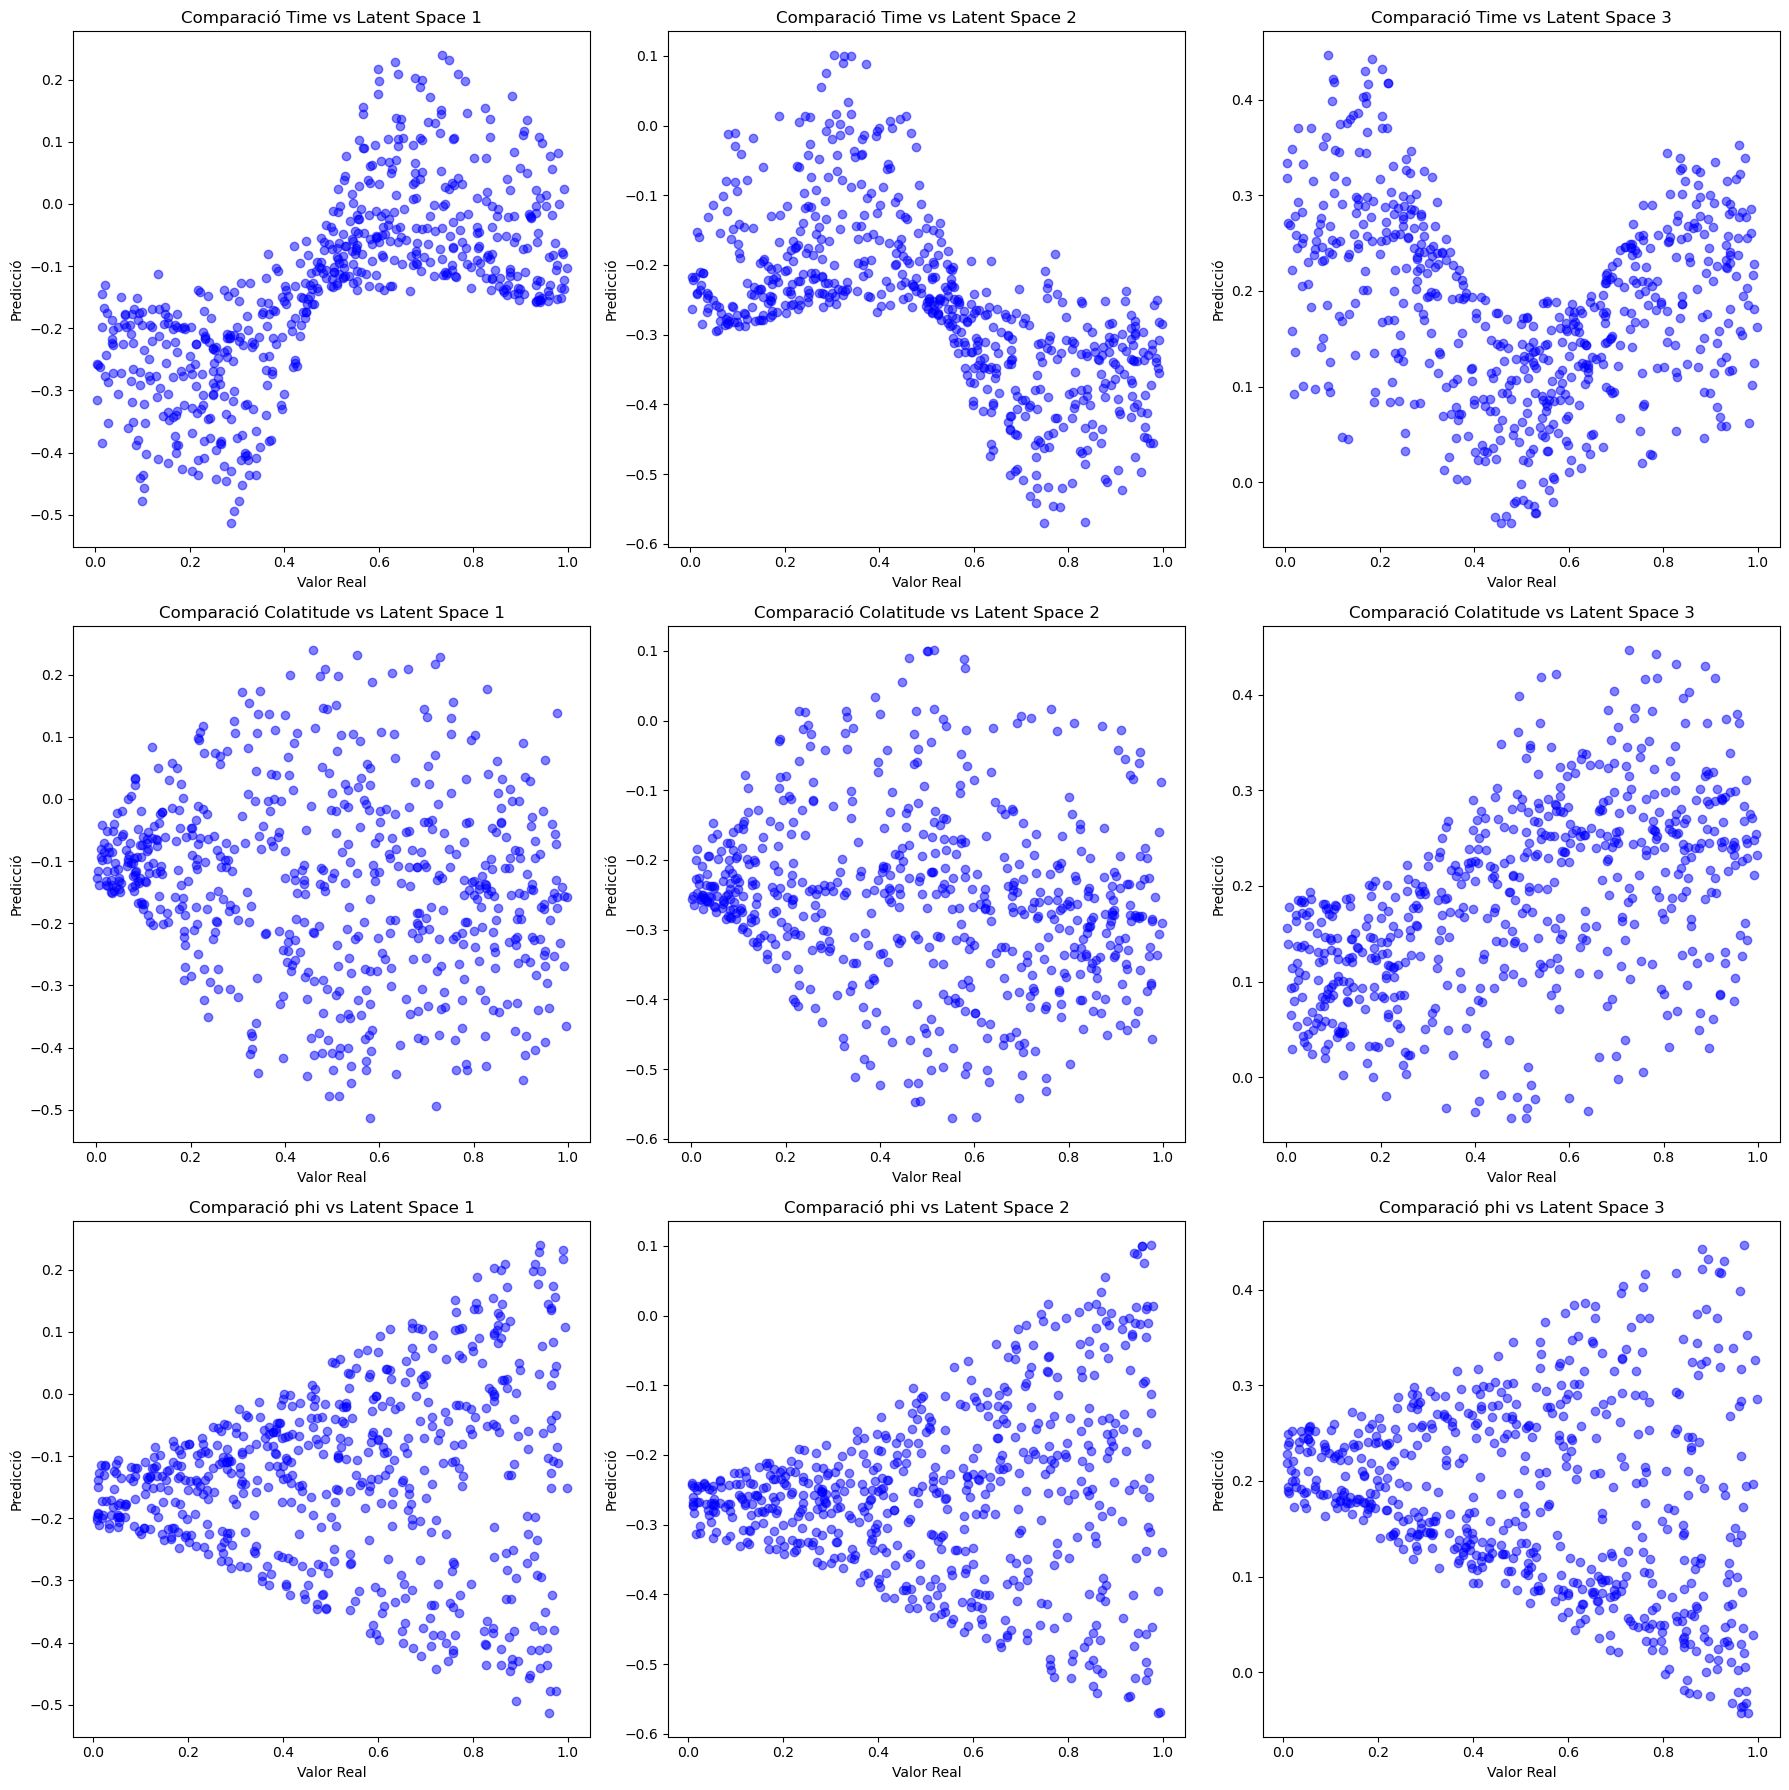

In [79]:
# evaluation
model.eval()
with torch.no_grad():
    reconstructed, predict = model(ccf_test)


reconstructed = reconstructed.numpy()
predict = predict.numpy()
parametres = params_test.numpy()


# plot curves

# Comprovació d'una corba concreta

plt.figure(figsize=(10, 5))

colors = ['darkred', 'darkblue', 'darkgreen', 'darkorange', 'purple']
colors_light = ['lightcoral', 'lightblue', 'lightgreen', 'peachpuff', 'plum']

for i in range(5):
    # Corba original en punts petits i color clar
    plt.plot(ccf_test[i][0].numpy(), 'o', 
             color=colors_light[i], 
             label=f'Original {i+1}', 
             markersize=6, alpha=0.9)
    
    # Corba reconstruïda en línia contínua i color fosc
    plt.plot(reconstructed[i][0], 
             color=colors[i], 
             label=f'Reconstruïda {i+1}', 
             linewidth=1.5)

plt.legend()
plt.title("Corbes originals vs reconstruïdes")
plt.savefig('ccfs_orig_recons.png')
plt.show()

# plot

titles = ['Time','Colatitude','phi']
plt.figure(figsize=(18, 18))
for i in range(3):
    for j in range(3):
        plt.subplot(3, 3, i*3+j+1)
        plt.scatter(parametres[:, i], predict[:, j], color='blue', alpha=0.5)
        plt.title(f'Comparació {titles[i]} vs Latent Space {j+1}')
        plt.xlabel("Valor Real")
        plt.ylabel("Predicció")

plt.tight_layout()
plt.savefig('plot.png')
plt.show()


#### Espai Latent 3D

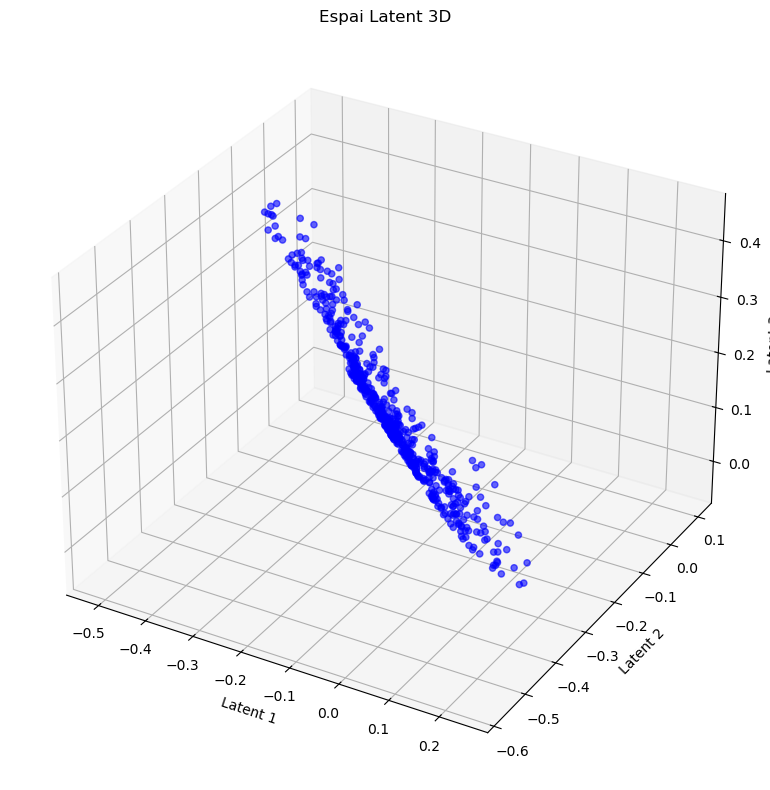

In [67]:
# Crear figura i eixos 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot 3D
ax.scatter(predict[:, 0], predict[:, 1], predict[:, 2], c='blue', alpha=0.6)

# Etiquetes
ax.set_xlabel('Latent 1')
ax.set_ylabel('Latent 2')
ax.set_zlabel('Latent 3')
ax.set_title('Espai Latent 3D')

plt.tight_layout()
plt.savefig("latent_space_3d.png", dpi=300)
plt.show()
